In [31]:
from PIL import Image, ImageSequence
import numpy as np
image_tiff = Image.open("/home/marco/Base_Patrones/datos_tarea2/datos_tarea2/segmentacion_referencia.tif")

images_ref = []
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_ref.append(np.array(page))
    
image_tiff = Image.open("/home/marco/Base_Patrones/datos_tarea2/datos_tarea2/raw.tif")

images_raw=[]
for i, page in enumerate(ImageSequence.Iterator(image_tiff)):
    images_raw.append(np.array(page))
    

In [29]:
print(len(images_ref),len(images_raw))

55 55


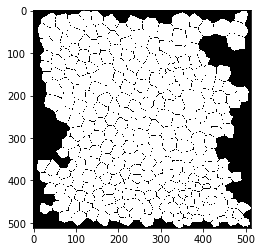

In [32]:
from pylab import imread,subplot,imshow,title,gray,figure,show,NullLocator

figure()
gray()
imshow(images_ref[40])
show()

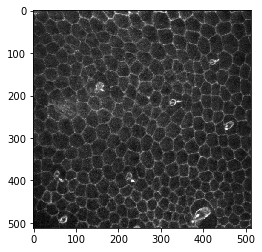

In [34]:
figure()
gray()
imshow(images_raw[40])
show()